In [1]:
%matplotlib widget
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import art3d


In [2]:
# params
nx, nu = 3, 3
T = 30
dt = 0.1
lu = -1. # lower bound on u
hu = 1.  # higher bound on u
gripper = 1. # 1. means the gripper is open
tolerance = 0.0005 # tolerance when gripper has cube under grasp
    
# dynamics
A = np.zeros((nx, nx))
B = np.eye(nx)
Ad = np.eye(nx) + A * dt
Bd = B * dt

In [3]:
# variables
x = cp.Variable((T+1, nx), name='x')
u = cp.Variable((T, nu), name='u')

    # parameters
x0 = cp.Parameter(nx, name="x0")
xd = cp.Parameter(nx, name="xd")
x0.value = np.zeros((nx,))
xd.value = np.zeros((nx,))

In [4]:
# constraints
constraints = []
# upper and lower bounds
constraints += [u <= hu*np.ones((T, nu))]
constraints += [u >= lu*np.ones((T, nu))]
# initial cond
constraints += [x[0] == x0]
# dynamics
for t in range(T):
  constraints += [x[t+1] == Ad @ x[t] + Bd @ u[t]]

In [5]:
# objective
obj = cp.Minimize(cp.norm(x[-1] - xd))

In [6]:
# put toghether problem
prob = cp.Problem(obj, constraints)

In [57]:
x0.value = np.zeros(3)
xd.value = 0.6*np.ones(3)

prob.solve(solver='MOSEK')


1.7470452524264795e-09

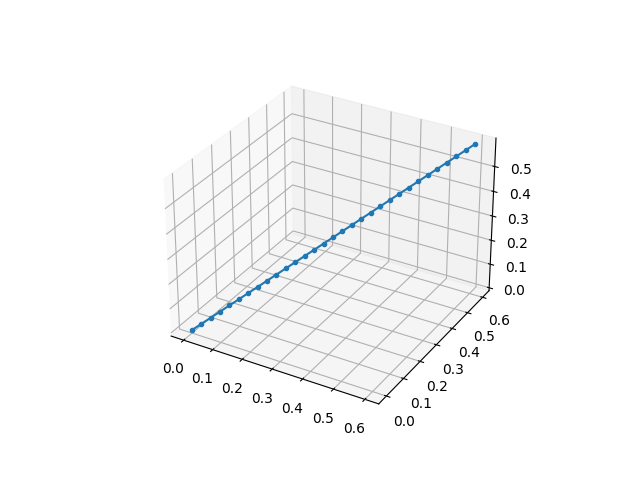

In [8]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory
ax.plot(x.value[:,0], x.value[:,1], x.value[:,2], '.-')

In [9]:
# obstacle
x_obs = 0.5*np.ones(3)
x_obs_T = np.vstack([x_obs for _ in range(T+1)])
r_obs = 0.1


In [10]:
# variables
x_scp = cp.Variable((T+1, nx), name='x')
u_scp = cp.Variable((T, nu), name='u')
v_scp_dyn = cp.Variable((T+1, 1), name='v_dyn')
v_scp_const = cp.Variable((T+1, 1), name='v_const')

In [11]:
# constraints
constraints_scp = []
# upper and lower bounds
constraints_scp += [u_scp <= 0.5 * hu*np.ones((T, nu))]
constraints_scp += [u_scp >= 0.5 * lu*np.ones((T, nu))]
# initial cond
constraints_scp += [x_scp[0] == x0]
# dynamics
for t in range(T):
  constraints_scp += [x_scp[t+1] == Ad @ x_scp[t] + Bd @ u_scp[t] + np.ones(3)*v_scp_dyn[t]]

In [52]:
x_bar = x_scp.value
distance_norm = np.linalg.norm(x_bar - x_obs_T, 2, axis=1)
scp_const = []
for t in range(T+1):
  nt = distance_norm[t]
  scp_const += [(x_bar[t] - x_obs).T/nt @ (x_bar[t]-x_scp[t]) + r_obs - nt <= v_scp_const[t]]

In [53]:
# objective
l = 1000
obj_scp = cp.Minimize(cp.norm(x_scp[-1] - xd) + l * cp.norm(3*v_scp_dyn, 1) + l * cp.norm(v_scp_const, 1))

In [54]:
scp_prob = cp.Problem(obj_scp, constraints_scp + scp_const)
scp_prob.solve(solver='MOSEK')

2.696989937329528e-10

In [55]:
#print(x_scp.value)
#print(v_scp.value)
print(np.linalg.norm(x_scp.value - x_obs_T, axis=1))

[0.8660254  0.84612937 0.8263967  0.8055556  0.78375228 0.76074604
 0.73662156 0.71163891 0.68549314 0.65824401 0.63009659 0.60087056
 0.57005513 0.53888306 0.5067964  0.47347363 0.43959303 0.40539499
 0.37103245 0.33699982 0.30387668 0.27287922 0.24562086 0.22476996
 0.20982567 0.20210016 0.19715532 0.18877719 0.17610366 0.17173136
 0.17320508]


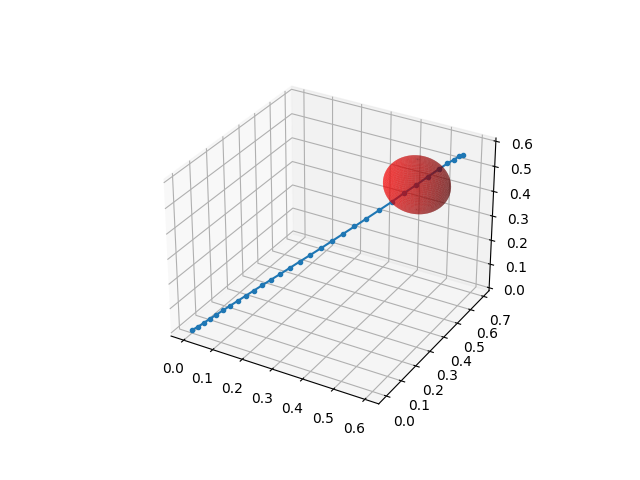

In [56]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory
ax.plot(x_scp.value[:,0], x_scp.value[:,1], x_scp.value[:,2], '.-')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 50)
x_sphere = x_obs[0] + r_obs * np.outer(np.cos(u), np.sin(v))
y_sphere = x_obs[1] + r_obs * np.outer(np.sin(u), np.sin(v))
z_sphere = x_obs[2] + r_obs * np.outer(np.ones(np.size(u)), np.cos(v))
sphere = ax.plot_surface(x_sphere, y_sphere, z_sphere, color='r', alpha=0.5)